In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import requests

from tools import *

### Get list of S&P 500 companies

In [2]:
sp500 = get_sp500_list()
sp500.head(3)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888


In [3]:
sectors = sp500['GICS Sector'].value_counts().reset_index().rename(columns={'index':'Sector'})
sectors 

,Sector,GICS Sector
0,Industrials,74
1,Information Technology,74
2,Financials,65
3,Health Care,64
4,Consumer Discretionary,63
5,Consumer Staples,32
6,Real Estate,29
7,Materials,28
8,Utilities,28
9,Communication Services,26


In [15]:
nas15 = pd.read_csv("Assorted/20210615. nasdaq_screener_1623818257700.csv")[['Symbol', 'Name', 'Market Cap', 'Last Sale']]
nas16 = pd.read_csv("Assorted/20210616_nasdaq_screener_1623904495113.csv")[['Symbol', 'Name', 'Market Cap', 'Last Sale']]

In [21]:
nas15

,Symbol,Name,Market Cap,Last Sale
0,AACG,ATA Creativity Global American Depositary Shares,9.890771e+07,$3.12
1,AACQ,Artius Acquisition Inc. Class A Common Stock,9.074362e+08,$10.02
2,AACQU,Artius Acquisition Inc. Unit,0.000000e+00,$10.86
3,AACQW,Artius Acquisition Inc Warrant,0.000000e+00,$2.50
4,AAL,American Airlines Group Inc. Common Stock,1.461712e+10,$22.79
...,...,...,...,...
4289,ZWRKU,Z-Work Acquisition Corp. Units,0.000000e+00,$9.95
4290,ZWRKW,Z-Work Acquisition Corp. Warrant,0.000000e+00,$0.73
4291,ZY,Zymergen Inc. Common Stock,4.386199e+09,$43.72
4292,ZYNE,Zynerba Pharmaceuticals Inc. Common Stock,2.239958e+08,$5.43


In [106]:
# pd.concat([nas15, nas16], axis=1, )
merged = pd.merge(nas15, nas16, on=['Symbol', 'Name'])#.dropna()
merged['Last Sale_x'] = merged['Last Sale_x'].replace('[\$,]', '', regex=True).astype(float)
merged['Last Sale_y'] = merged['Last Sale_y'].replace('[\$,]', '', regex=True).astype(float)
merged['n_shares15'] = merged['Market Cap_x'] / merged['Last Sale_x']
merged['n_shares16'] = merged['Market Cap_y'] / merged['Last Sale_y']
merged['n_shared_diff'] =  (merged['n_shares15'] - merged['n_shares16'])/ merged['n_shares16']
merged[merged['n_shared_diff'] > 0.01]

,Symbol,Name,Market Cap_x,Last Sale_x,Mkt_cap_label,Market Cap_y,Last Sale_y,n_shares15,n_shares16,n_shared_diff
262,ANY,Sphere 3D Corp. Common Shares,54907280.0,2.78,Penny,46674509.0,2.45,1.975082e+07,1.905082e+07,0.036744
3207,RACA,Therapeutics Acquisition Corp. Class A Common ...,182630378.0,10.22,Penny,177821700.0,10.20,1.786990e+07,1.743350e+07,0.025032
3523,SLS,SELLAS Life Sciences Group Inc. Common Stock,578225000.0,11.45,Small,175982095.0,11.39,5.050000e+07,1.545058e+07,2.268486
4122,WETF,WisdomTree Investments Inc. Common Stock,991793249.0,6.63,Small,964860084.0,6.65,1.495917e+08,1.450917e+08,0.031015


### Filtering

In [105]:
nas15 = nas15.dropna()
bins = [-1, 3e+8, 2e+9, 10e+9, 100e+9, 10000e+9]
nas15['Mkt_cap_label'] = pd.cut(nas15['Market Cap'], bins=bins, labels=['Penny','Small', 'Medium', 'Large', "Mega"])
nas15.sort_values(by='Market Cap', ascending=False).head(40)

,Symbol,Name,Market Cap,Last Sale,Mkt_cap_label
8,AAPL,Apple Inc. Common Stock,2.247613e+12,$129.64,Mega
2605,MSFT,Microsoft Corporation Common Stock,1.945858e+12,$258.36,Mega
247,AMZN,Amazon.com Inc. Common Stock,1.706193e+12,$3383.13,Mega
1680,GOOG,Alphabet Inc. Class C Capital Stock,1.689255e+12,$2520.66,Mega
1681,GOOGL,Alphabet Inc. Class A Common Stock,1.627419e+12,$2428.39,Mega
1344,FB,Facebook Inc. Class A Common Stock,9.548428e+11,$336.75,Mega
3900,TSLA,Tesla Inc. Common Stock,5.773817e+11,$599.36,Mega
2778,NVDA,NVIDIA Corporation Common Stock,4.432894e+11,$711.54,Mega
3194,PYPL,PayPal Holdings Inc. Common Stock,3.193968e+11,$271.89,Mega
343,ASML,ASML Holding N.V. New York Registry Shares,2.923012e+11,$701.78,Mega


               Market Cap
Mkt_cap_label            
Penny                2189
Small                1236
Medium                570
Large                 252
Mega                   34


<AxesSubplot:xlabel='Mkt_cap_label'>

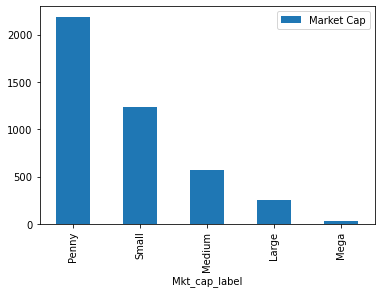

In [103]:
print(nas15.groupby('Mkt_cap_label').count()[['Market Cap']])
nas15.groupby('Mkt_cap_label').count()[['Market Cap']].plot(kind='bar')